In [9]:
import sys
sys.path.insert(0, '../')
from lib.io_functions import load_npy, save_proccesed_variables
from lib.fit_functions import fit_wvfs,scfunc
from lib.sim_functions import rand_scint_times
from lib.wvf_functions import find_baseline_cuts
from lib.dec_functions import deconvolve

import numpy as np
import matplotlib.pyplot as plt
from itertools import product

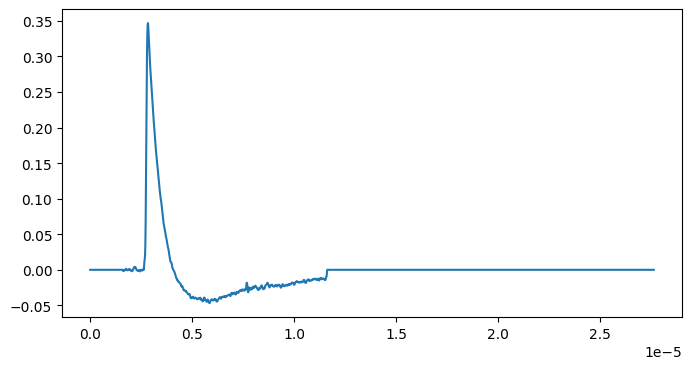

In [10]:
show = True
expand_array = 1000

# Load data for wvf template (LARSOFT)
raw_SER = open("../larsoft/PDS/SPE_maritza.txt")
SER = np.asarray(raw_SER.readlines()).astype(float)

# Load data for wvf template (LAB)
# lab_run = load_npy([2],[6],"Average_","../data/ave/")
# SER = lab_run[2][6]["SPEAvWvf"]

# Load data for wvf template (LAB)
# lab_run = load_npy([2],[0],"Average_","../data/ave/")
# SER = lab_run[2][0]["SPEAvWvf"]

# Generate empty array to import data
SER = np.append(np.asarray(SER),np.zeros(expand_array))
SER = np.append(np.zeros(100),np.asarray(SER))

# Generate dict with required structure
my_run = dict()

my_run["NRun"] = [0]
my_run["NChannel"] = [0]

my_run[0] = dict()
my_run[0][0] = dict()
my_run[0][0]["ADC"] = [np.array(SER)]
my_run[0][0]["Sampling"] = 16e-9
# my_run[0][0]["Sampling"] = 4e-9

if show == True:
    plt.figure(figsize=(8,4))
    plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["ADC"][0])),my_run[0][0]["ADC"][0])
    plt.show()


In [11]:
dec_label = ["Gauss","Wiener"]
key = ["ADC","FitSC","DecADC"]
opt = {
    "SHOW": False,
    "NOISE_AMP": 0.5,
    "FIX_EXP":True,
    "WIENER_BUFFER": 100,
    "FILTER": "Gauss",
    "PRO_RODRIGO": False,
    "CONVERT_ADC": True
    }

# One can substitute the template with a fit
param = fit_wvfs(my_run,"SC",1e-4,fit_range=[0,len(SER)-expand_array],OPT=opt)
max_idx = np.argmax(my_run[0][0][key[1]][0])
pre = len(my_run[0][0][key[1]][0][:max_idx])
post = len(my_run[0][0][key[1]][0][max_idx:])

deconvolve(my_run,my_run,my_run,key,opt) # Sanity check deconvolution

opt["FILTER"] = "WIENER"
deconvolve(my_run,my_run,my_run,key,opt) # Sanity check deconvolution

spe_factor = np.trapz(my_run[0][0]["ADC"][0],my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["ADC"][0])))
raw_factor = np.trapz(my_run[0][0]["ADC"][0],my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["ADC"][0])))
# print(spe_factor)

Fitting wvf  0


Generated wvfs with key GaussDecADC
Generated wvfs with key WienerDecADC


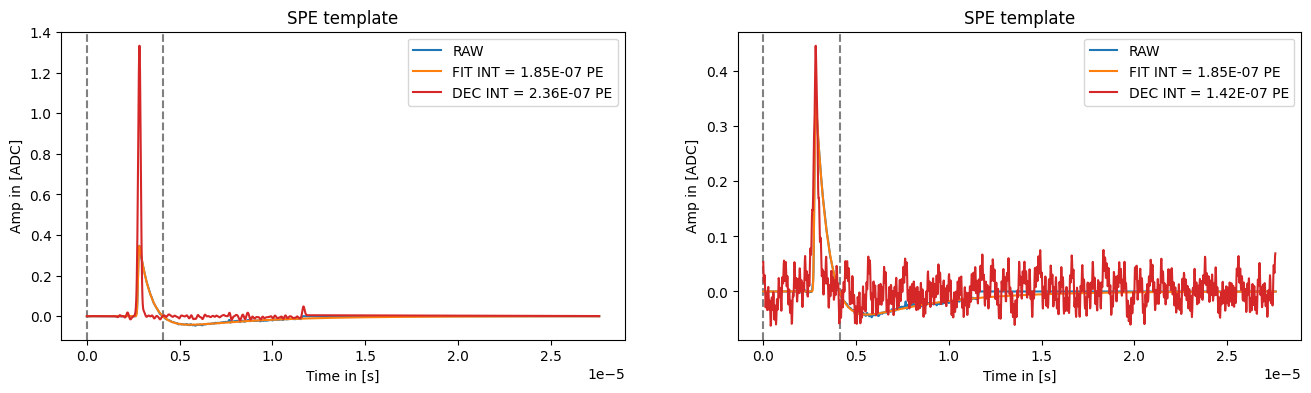

In [12]:
# %matplotlib qt
i_idx,f_idx = find_baseline_cuts(my_run[0][0][key[1]][0])

if show == True:
    fig,ax = plt.subplots(1,2,figsize=(16,4))
    for i in range(2):
        fit_charge = np.trapz(my_run[0][0][key[1]][0][i_idx:f_idx],my_run[0][0]["Sampling"]*np.arange(f_idx-i_idx))
        dec_charge = np.trapz(my_run[0][0][dec_label[i]+key[2]][0][i_idx:f_idx],my_run[0][0]["Sampling"]*np.arange(f_idx-i_idx))
        ax[i].set_title("SPE template")
        ax[i].set_xlabel("Time in [s]")
        ax[i].set_ylabel("Amp in [ADC]")
        ax[i].axvline(my_run[0][0]["Sampling"]*i_idx,ls="--",c="grey")
        ax[i].axvline(my_run[0][0]["Sampling"]*f_idx,ls="--",c="grey")
        ax[i].plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][key[0]][0])),my_run[0][0]["ADC"][0],label="RAW")
        ax[i].plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][key[1]][0])),my_run[0][0][key[1]][0],label="FIT INT = %.2E PE"%fit_charge)
        ax[i].plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][dec_label[i]+key[2]][0])),my_run[0][0][dec_label[i]+key[2]][0],c="tab:red",label="DEC INT = %.2E PE"%dec_charge)
        ax[i].legend()
    plt.show()

In [13]:
my_run[0][0]["McADC"] = []
MC_num = 1000
for i in range(MC_num):
    times = rand_scint_times(50,slow=6e-9,fast=1e-6,ratio=0.15)
    peaks = [];wvf = []; this_wvf = []

    times_array = np.linspace(0,20e-6,int(20e-6/my_run[0][0]["Sampling"])+1)
    wvf = np.zeros(pre+len(times_array)+post)

    # print(len(wvf))
    for t in times:
        this_peak = int((t-(t%my_run[0][0]["Sampling"]))/my_run[0][0]["Sampling"])
        peaks.append(this_peak)
        this_wvf = np.zeros(pre+this_peak)
        this_wvf = np.append(this_wvf,my_run[0][0]["FitSC"][0])
        this_wvf = np.append(this_wvf,np.zeros(len(wvf)-len(this_wvf)))
        wvf = wvf+this_wvf
    my_run[0][0]["McADC"].append(wvf)
my_run[0][0]["McNoiseADC"] = np.asarray(my_run[0][0]["McADC"])+np.random.normal(0,np.max(SER)*0.5,size=[len(my_run[0][0]["McADC"]),len(my_run[0][0]["McADC"][0])])


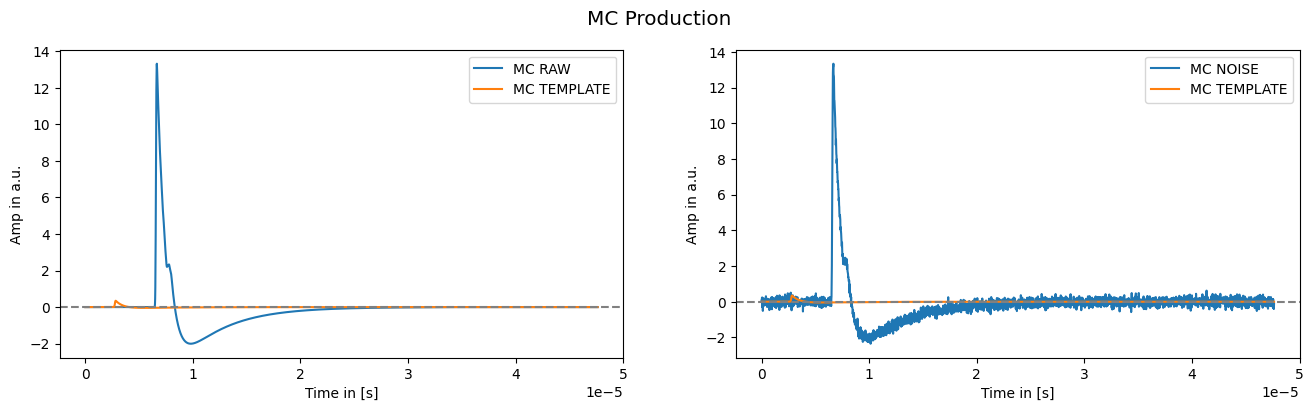

In [14]:
my_run[0][0]["FitSC"][0] = scfunc(np.arange(len(my_run[0][0]["McNoiseADC"][0])),*param)
num = np.random.randint(0,MC_num)

if show == True:
    fig, ax = plt.subplots(1,2,figsize=(16,4))
    fig.suptitle("MC Production", fontsize="x-large")
    ax[0].plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["McADC"][num])),my_run[0][0]["McADC"][num],c="tab:blue",label="MC RAW")
    ax[0].plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["McADC"][num])),scfunc(np.arange(len(my_run[0][0]["McADC"][num])),*param),c="tab:orange",label="MC TEMPLATE")

    ax[1].plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["McNoiseADC"][num])),my_run[0][0]["McNoiseADC"][num],c="tab:blue",label="MC NOISE")
    ax[1].plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["McNoiseADC"][num])),scfunc(np.arange(len(my_run[0][0]["McNoiseADC"][num])),*param),c="tab:orange",label="MC TEMPLATE")
    for i in range(len(ax)):
        ax[i].set_xlabel("Time in [s]")
        ax[i].set_ylabel("Amp in a.u.")
        ax[i].axhline(0,c="grey",ls="--")
        ax[i].legend()
    plt.show()

In [15]:
OPT = {
    "NOISE_AMP": 0.5, # Noise amp as a factor of SPE max.
    "FIX_EXP":True,
    "WIENER_BUFFER": 200,
    "FILTER": "WIENER",
    "CONVERT_ADC": True
    }

KEY = ["McADC","FitSC","DecADC"]
deconvolve(my_run,my_run,my_run,KEY,OPT)

KEY = ["McNoiseADC","FitSC","DecNoiseADC"]
deconvolve(my_run,my_run,my_run,KEY,OPT)

OPT["FILTER"] = "GAUSS"

KEY = ["McADC","FitSC","DecADC"]
deconvolve(my_run,my_run,my_run,KEY,OPT)

KEY = ["McNoiseADC","FitSC","DecNoiseADC"]
deconvolve(my_run,my_run,my_run,KEY,OPT)


Generated wvfs with key WienerDecADC
Generated wvfs with key WienerDecNoiseADC
Generated wvfs with key GaussDecADC
Generated wvfs with key GaussDecNoiseADC


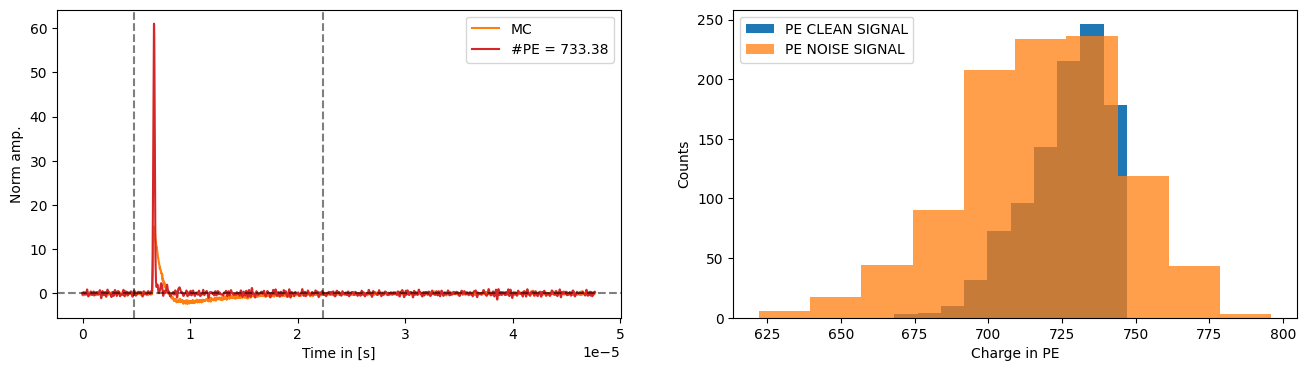

In [16]:
# %matplotlib qt
show = True
norm = False

filter_key = "Gauss"
# filter_key = "Wiener"

raw_key = "McNoiseADC"
dec_key = "DecNoiseADC"

# raw_key = "McADC"
# dec_key = "DecADC"

i_idx = 300
f_idx = 1400

charge = np.sum(my_run[0][0][filter_key+"DecADC"][:,i_idx:f_idx],axis=1)
noise_charge = np.sum(my_run[0][0][filter_key+"DecNoiseADC"][:,i_idx:f_idx],axis=1)

if show == True:
    fig,ax = plt.subplots(1,2,figsize=(16,4))
    plt.xlabel("Time in [s]")
    plt.ylabel("Amp in a.u.")
    my_run[0][0].keys()
    num = np.random.randint(0,MC_num)
    if norm == True:
        ax[0].plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][raw_key][num])),my_run[0][0][raw_key][num]/np.max(my_run[0][0][raw_key][num]),label="MC",c="tab:orange")
        ax[0].plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][filter_key+dec_key][num])),my_run[0][0][filter_key+dec_key][num]/np.max(my_run[0][0][filter_key+dec_key][num]),label="#PE = %.2f"%charge[num],c="tab:red")
    else:
        ax[0].plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][raw_key][num])),my_run[0][0][raw_key][num],label="MC",c="tab:orange")
        ax[0].plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][filter_key+dec_key][num])),my_run[0][0][filter_key+dec_key][num],label="#PE = %.2f"%charge[num],c="tab:red")
    ax[0].axhline(0,ls="--",alpha=0.5,c="black")
    ax[0].axvline(i_idx*my_run[0][0]["Sampling"],ls="--",alpha=0.5,c="black")
    ax[0].axvline(f_idx*my_run[0][0]["Sampling"],ls="--",alpha=0.5,c="black")
    ax[0].set_ylabel("Norm amp.")
    ax[0].set_xlabel("Time in [s]")

    ax[1].set_ylabel("Counts")
    ax[1].set_xlabel("Charge in PE")
    ax[1].hist(charge,alpha=1,label="PE CLEAN SIGNAL")
    ax[1].hist(noise_charge,alpha=.75,label="PE NOISE SIGNAL")
    
    ax[0].legend()
    ax[1].legend()
    plt.show()